# <font size=6 color='green'><center>**Static Architecture**</center></font>
### **<center>Part 2<br/>**

Here, we are gonna train the modality shared network by using the modality specific face and voice subnetworks trained in part 1
The inputs consist of (audio, face1, face2) and ouptut consist of a label, where label = 0 indicates audio matches with face1 and label = 1 if audio matches with face2

In [3]:
# importing required libraries
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

Loading the data using tensorflow data generators for efficient memory usage

In [73]:
# function that parses the tf record
def parser(tfRecord):
   keys_to_features = {
        "image1_raw": tf.io.FixedLenFeature([], tf.string),
        "image2_raw": tf.io.FixedLenFeature([], tf.string),
        "audio_raw": tf.io.FixedLenFeature([], tf.string),
        "label":     tf.io.FixedLenFeature([], tf.int64)
    }
   
   parsed = tf.io.parse_single_example(tfRecord, keys_to_features)
   image1 = tf.io.parse_tensor(parsed['image1_raw'], out_type=tf.float64)
   image2 = tf.io.parse_tensor(parsed['image2_raw'], out_type=tf.float64)
   audio = tf.io.parse_tensor(parsed['audio_raw'], out_type=tf.double)
   audio = tf.expand_dims(audio,axis=2)
   label = tf.cast(parsed['label'], tf.int32)
   label = tf.one_hot(label,2)
   return {'faceInput1':image1,'faceInput2':image2,'voiceInput':audio}, label
 
# function to load dataset from the tfrecords file
def get_train_data(filenames):
  dataset = tf.data.TFRecordDataset(filenames=filenames, num_parallel_reads=40)
  dataset = dataset.map(parser, num_parallel_calls=12)
  dataset = dataset.batch(batch_size=32)
  dataset = dataset.prefetch(buffer_size=2)
  return dataset

In [74]:
# change this path to the path file of tensorflow records
inputDataPath = 'train2.tfrecords'
trainDataset = get_train_data(inputDataPath)

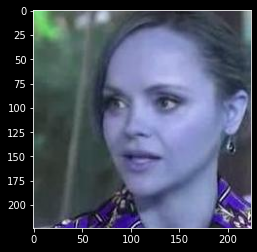

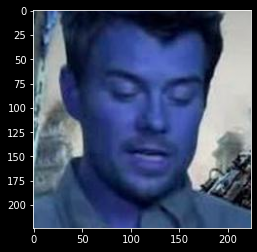

Shape of the mfcc co-efficients: (20, 130, 1)


In [75]:
# show a sample images and mfccs
X_data, labels = next(iter(trainDataset))

# plotting the image input
plt.imshow(X_data['faceInput1'][0])
plt.show()
plt.imshow(X_data['faceInput2'][0])
plt.show()

mfcc=X_data['voiceInput'][0]
print(f"Shape of the mfcc co-efficients: {mfcc.shape}")

In [64]:
# defining the face and voice subnetworks as sequential models
faceSubnet = keras.models.Sequential()

faceSubnet.add(keras.layers.Conv2D(filters=96, kernel_size=(7,7), trainable=False, strides=(2,2), padding="same", activation="relu", name='flayer1i',input_shape=(224,224,3)))

faceSubnet.add(keras.layers.MaxPool2D(pool_size=(2,2),padding="valid",name="flayer1o", trainable=False))

faceSubnet.add(keras.layers.Conv2D(filters=256, kernel_size=(5,5), trainable=False, strides=(2,2), padding="same", activation="relu",name='flayer2i'))

faceSubnet.add(keras.layers.MaxPool2D(pool_size=(2,2), trainable=False, padding="valid",name='flayer2o'))

faceSubnet.add(keras.layers.Conv2D(filters=256, kernel_size=(3,3), trainable=False, strides=(1,1),padding="same", activation="relu",name='flayer3i'))

faceSubnet.add(keras.layers.MaxPool2D(pool_size=(2,2), trainable=False, padding="valid",name='flayer3o'))

faceSubnet.add(keras.layers.Dense(units=4096, trainable=False, activation='relu',name='flayer4i'))

faceSubnet.add(keras.layers.Flatten(name='flayer40', trainable=False))

faceSubnet.add(keras.layers.Dense(units=1024, trainable=False, activation='relu',name='flayer5i'))

# defining the voice subnet

voiceSubnet = keras.models.Sequential()

voiceSubnet.add(keras.layers.Conv2D(filters=96, kernel_size=(7,7), strides=(2,2), padding="same", activation="relu",name='vlayer1i',input_shape=(20,130,1)))

voiceSubnet.add(keras.layers.MaxPool2D(pool_size=(2,2),padding="valid",name='vlayer1o'))

voiceSubnet.add(keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(2,2), padding="same", activation="relu",name='vlayer2i'))

voiceSubnet.add(keras.layers.MaxPool2D(pool_size=(2,2), padding="valid",name='vlayer2o'))

voiceSubnet.add(keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1),padding="same", activation="relu",name='vlayer3i'))

voiceSubnet.add(keras.layers.MaxPool2D(pool_size=(1,2), padding="valid",name='vlayer3o'))

voiceSubnet.add(keras.layers.Dense(units=4096, activation='relu',name='vlayer4i'))

voiceSubnet.add(keras.layers.Flatten(name='valyer4o'))

voiceSubnet.add(keras.layers.Dense(units=1024, activation='relu',name='vlayer5i'))


In [65]:
# load the layer weights on the basis of layer names
# from the model built in part 1
faceSubnet.load_weights('staticModel1.h5',by_name=True)
voiceSubnet.load_weights('staticModel1.h5',by_name= True)

faceSubnet.trainable=False
voiceSubnet.trainable=False

In [66]:
# clear
faceInput1 = keras.layers.Input(shape=(224,224,3), name='faceInput1')
faceInput2 = keras.layers.Input(shape=(224,224,3), name='faceInput2')
voiceInput = keras.layers.Input(shape=(20,130,1), name='voiceInput')
faceFeatures1 = faceSubnet(faceInput1)
faceFeatures2 = faceSubnet(faceInput2)
voiceFeatures = voiceSubnet(voiceInput)

In [69]:
concatenatedLayers = keras.layers.concatenate([faceFeatures1, faceFeatures2, voiceFeatures])
clayer1 = keras.layers.Dense(units=2048, activation='relu',name='clayer1')
clayer2 = keras.layers.Dense(units=512, activation='relu', name='clayer2')
clayer3 = keras.layers.Dense(units=2, activation='sigmoid',name='clayer3')
finalOutput = clayer3(clayer2(clayer1(concatenatedLayers)))

In [70]:
model = keras.Model(
  inputs = [faceInput1, faceInput2, voiceInput],
  outputs = finalOutput
)

In [71]:
model.compile()

In [72]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 faceInput1 (InputLayer)        [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 faceInput2 (InputLayer)        [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 voiceInput (InputLayer)        [(None, 20, 130, 1)  0           []                               
                                ]                                                           

Final architecture looks like this

In [76]:
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [77]:
model.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy']
)

In [79]:
history = model.fit(trainDataset,epochs = 15)

Epoch 1/15


1/1 [==============================] - 1s 649ms/step - loss: 0.6118 - accuracy: 0.6000
Epoch 2/15
1/1 [==============================] - 1s 724ms/step - loss: 1.1120 - accuracy: 0.6000
Epoch 3/15
1/1 [==============================] - 1s 696ms/step - loss: 1.1765 - accuracy: 0.6000
Epoch 4/15
1/1 [==============================] - 1s 664ms/step - loss: 0.8284 - accuracy: 0.6000
Epoch 5/15
1/1 [==============================] - 1s 726ms/step - loss: 0.5873 - accuracy: 0.7000
Epoch 6/15
1/1 [==============================] - 1s 654ms/step - loss: 0.8397 - accuracy: 0.4000
Epoch 7/15
1/1 [==============================] - 1s 634ms/step - loss: 0.8033 - accuracy: 0.4000
Epoch 8/15
1/1 [==============================] - 1s 651ms/step - loss: 0.5753 - accuracy: 0.9000
Epoch 9/15
1/1 [==============================] - 1s 575ms/step - loss: 0.6096 - accuracy: 0.6000
Epoch 10/15
1/1 [==============================] - 1s 634ms/step - loss: 0.6838 - accuracy: 0.6000
Epoch 11/15
1/1 [=============

In [ ]:
model.save_weights('staticModel2.h5')

---